# Lab.7: Word Sequences - Mandatory + Optional execises

Authors: Edison Jair Bejarano Sepulveda - Roberto Ariosa

## Mandatory statement:

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

2. Compute their similarities by considering the following approach:
  - words plus NEs and Jaccard coefficient ex: word_and_NEs=['John Smith', 'is', 'working']

3. Show the results.

4. Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.


## Import libraries

In [1]:
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp "/content/drive/MyDrive/Colab_Notebooks/2.IHLT/test-gold.tar" .
!tar -xvf /content/test-gold.tar

test-gold/
test-gold/STS.input.MSRpar.txt
test-gold/STS.gs.MSRpar.txt
test-gold/STS.input.MSRvid.txt
test-gold/STS.gs.MSRvid.txt
test-gold/STS.input.SMTeuroparl.txt
test-gold/STS.gs.SMTeuroparl.txt
test-gold/STS.input.surprise.SMTnews.txt
test-gold/STS.gs.surprise.SMTnews.txt
test-gold/STS.input.surprise.OnWN.txt
test-gold/STS.gs.surprise.OnWN.txt
test-gold/STS.gs.ALL.txt
test-gold/00-readme.txt


In [4]:
import os
import nltk
import svgling
import pandas as pd
from nltk.metrics import jaccard_distance
from scipy.stats import pearsonr
nltk.download('maxent_ne_chunker')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Function helpers

In [5]:
##################################
# Similarity Function
##################################
def jaccard_similarity(s1, s2):
  intersection = len(s1.intersection(s2))
  union = len(s1) + len(s2) - intersection
  return float(intersection) / float(union)


##################################
# Calcualte Similarity to Row
##################################
def calculate_similarity(row):
  sentence_1 = row['Text1']
  sentence_2 = row['Text2']

  ws1 = set(sentence_1)
  ws2 = set(sentence_2)

  return jaccard_similarity(ws1, ws2)


## Read all pairs of sentences

In [6]:
##################################
# Path test gold directory
##################################
path = '/content/test-gold'

In [7]:
##################################
# Read dataset and return a list 
# with the files 
##################################
files = sorted(os.listdir(path))
files = pd.DataFrame(files)
files = path+"/"+files
files

,0
0,/content/test-gold/00-readme.txt
1,/content/test-gold/STS.gs.ALL.txt
2,/content/test-gold/STS.gs.MSRpar.txt
3,/content/test-gold/STS.gs.MSRvid.txt
4,/content/test-gold/STS.gs.SMTeuroparl.txt
5,/content/test-gold/STS.gs.surprise.OnWN.txt
6,/content/test-gold/STS.gs.surprise.SMTnews.txt
7,/content/test-gold/STS.input.MSRpar.txt
8,/content/test-gold/STS.input.MSRvid.txt
9,/content/test-gold/STS.input.SMTeuroparl.txt


In [8]:
##################################
# Path test gold directory
##################################
da = files[0][9]
df = pd.read_csv(da, sep='\t', header=None)
df.columns = ['Text1', 'Text2']

gold_file = files[0][4]
df["gs"] = pd.read_csv(gold_file, sep='\t', header=None)
df.head()

,Text1,Text2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Compute similarities

In [9]:
def NES(sentence: str, binary: bool):
  x = nltk.pos_tag(nltk.word_tokenize(sentence))
  res = nltk.ne_chunk(x, binary=binary)
  necs_and_words = set()
  for chunk in res:
        if hasattr(chunk, 'label'):
            # Add NE
            token = ' '.join(term[0] for term in chunk)
            necs_and_words.add(token)
        else:
            token = chunk[0]
            if token.isalnum():
                necs_and_words.add(token.lower())
  return necs_and_words
    

def calculate_nes_and_words_jaccard_similarity(row):
  sentence_1 = row['Text1']
  sentence_2 = row['Text2']

  # Calculate NES + words
  nes1 = NES(sentence_1, True)
  nes2 = NES(sentence_2, True)

  return jaccard_similarity(nes1, nes2)

df["original_similarity"] = df.apply(calculate_similarity, axis=1)
df["similarity"] = df.apply(calculate_nes_and_words_jaccard_similarity, axis=1)

## Display the results

In [10]:
pearson_corr = (pearsonr(df['original_similarity'], df['gs']))[0]
print(f"Original Pearson's correlation:\t\t", pearson_corr)

pearson_corr = (pearsonr(df['similarity'], df['gs']))[0]
print(f"Pearson's correlation with NERC:\t", pearson_corr)

Original Pearson's correlation:		 0.3971297709735514
Pearson's correlation with NERC:	 0.4397631756800301


## Conclusion

We can see that the Pearson correlation obtained (0.4398) with the NE tagging was superior to the original Pearson correlation (0.3971). So, we can conclude that it is useful to compute the NE tagging to compute the similarity between sentences.

## Optional exercise

Enlarge the previous grammar to parse the next sentence as follows:

```
[("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),("dog", "NN"),\
 ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN"), \
 ("in", "IN"), ("New", "NNP"), ("York", "NNP")]
```

![tree](https://gebakx.github.io/ihlt/s7/figures/tree.png)

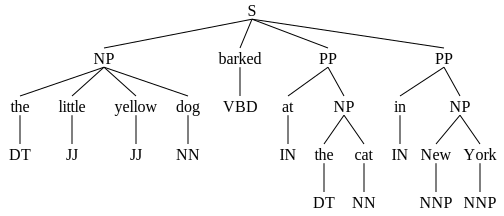

In [11]:
# Specify sentence
sentence = [
    ("the", "DT"),
    ("little", "JJ"),
    ("yellow", "JJ"),
    ("dog", "NN"),
    ("barked", "VBD"),
    ("at", "IN"),
    ("the", "DT"),
    ("cat", "NN"),
    ("in", "IN"),
    ("New", "NNP"),
    ("York", "NNP")
]

# Define grammar
grammar = """\
NP:
  {<DT>?<JJ>*<NN>}
  {<DT>?<NNP>+}
PP:
  {<IN><NP>}
"""

# Parse sentence
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)

# Draw resultant tree
svgling.draw_tree(result)